In [1]:
import sys, os
sys.path.insert(0, '/home/storage/hans/jax_reco_new/')

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
from lib.cgamma import c_multi_gamma_prob
from lib.cgamma_biweight_v2 import c_multi_gamma_biweight_prob
from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [3]:
closest_approach_dist = 2.0
closest_approach_rho = 0.0
closest_approach_z = -500
track_zenith = 0.0
track_azimuth = 0.0

x = jnp.array([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          track_zenith,
                          track_azimuth])

x_prime = transform_network_inputs(x)
y_pred = eval_network(x_prime)
logits, av, bv = transform_network_outputs(y_pred)
mix_probs = jax.nn.softmax(logits)

In [4]:
c_multi_gamma_prob_v = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_biweight_prob_v = jax.vmap(c_multi_gamma_biweight_prob, (0, None, None, None, None), 0)

In [5]:
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=av,    
            rate=bv,
            force_probs_to_zero_outside_support=True
              )
    )

In [6]:
xvals = np.linspace(-10, 100, 1000)
yvals_multi_gamma = gm.prob(xvals)

sigma=3.0
yvals_c_multi_gamma = c_multi_gamma_prob_v(xvals, mix_probs, av, bv, sigma, 0.1)
yvals_c_multi_gamma_biweight = c_multi_gamma_biweight_prob_v(xvals, mix_probs, av, bv, sigma*1.5)

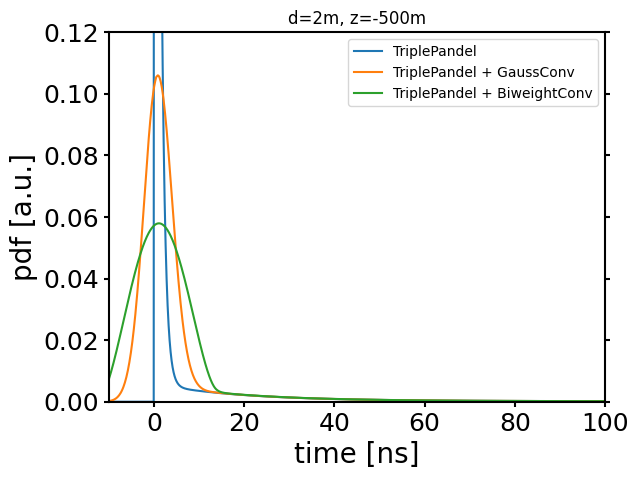

In [7]:
fig, ax = plt.subplots()

ax.plot(xvals, yvals_multi_gamma, label='TriplePandel')
ax.plot(xvals, yvals_c_multi_gamma, label='TriplePandel + GaussConv')
ax.plot(xvals, yvals_c_multi_gamma_biweight, label='TriplePandel + BiweightConv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 100], 
                 'ylim':[0.0, 0.12]}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"d={closest_approach_dist:.0f}m, z={closest_approach_z:.0f}m")
plt.show()


In [8]:
print(yvals_c_multi_gamma_biweight)

[0.00748898 0.00800748 0.00853951 0.00908455 0.0096421  0.01021163
 0.01079262 0.01138457 0.01198694 0.01259924 0.01322094 0.01385155
 0.01449055 0.01513744 0.01579173 0.01645293 0.01712054 0.01779408
 0.01847307 0.01915703 0.0198455  0.020538   0.02123408 0.02193328
 0.02263515 0.02333924 0.02404512 0.02475234 0.02546049 0.02616914
 0.02687786 0.02758625 0.0282939  0.02900041 0.02970537 0.03040841
 0.03110913 0.03180716 0.03250211 0.03319363 0.03388135 0.03456492
 0.03524398 0.03591819 0.0365872  0.03725069 0.03790832 0.03855978
 0.03920474 0.0398429  0.04047395 0.04109759 0.04171352 0.04232147
 0.04292114 0.04351226 0.04409456 0.04466778 0.04523165 0.04578592
 0.04633035 0.04686469 0.04738871 0.04790218 0.04840487 0.04889657
 0.04937706 0.04984614 0.0503036  0.05074925 0.05118291 0.05160438
 0.0520135  0.05241009 0.05279398 0.05316502 0.05352305 0.05386792
 0.0541995  0.05451764 0.05482222 0.05511311 0.0553902  0.05565337
 0.05590251 0.05613753 0.05635834 0.05656483 0.05675693 0.0569

In [9]:
from jax.scipy.special import gamma, gammainc, gammaincc


In [10]:
def branch0(x, a, b, s):
    # branch 0 (-s < x < +s)
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_3pa = gamma(3+a)
    g_4pa = gamma(4+a)

    bspx = b*(s+x)

    ginc_a = gammainc(a, bspx) * g_a 
    ginc_1pa = a * ginc_a - jnp.power(x, a) * jnp.exp(-x)
    ginc_2pa = (1+a) * ginc_1pa - jnp.power(x, 1+a) * jnp.exp(-x)
    ginc_3pa = (2+a) * ginc_2pa - jnp.power(x, 2+a) * jnp.exp(-x)
    ginc_4pa = (3+a) * ginc_3pa - jnp.power(x, 3+a) * jnp.exp(-x)

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    tsum0 = (
                ginc_a * t0
                + ginc_1pa * t1
                + ginc_2pa * t2
                + ginc_4pa
                + (g_3pa - ginc_3pa) * fbx
                - g_2pa * (2*fbx + a*fbx)
    )


    '''
    gincc_a = gammaincc(a, bspx) * g_a
    gincc_1pa = gammaincc(1+a, bspx)*g_1pa
    gincc_2pa = gammaincc(2+a, bspx)*g_2pa
    gincc_3pa = gammaincc(3+a, bspx)*g_3pa
    gincc_4pa = gammaincc(4+a, bspx)*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + (g_4pa - gincc_4pa)
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )
    '''

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum0


In [11]:
print(branch0(0.0, av[2], bv[2], 9.0))

446460.6219957662


In [12]:
print(av)
print(bv)

[1.00049647 1.10804905 1.00002877]
[0.05148044 1.29491227 0.00196719]


In [13]:
x = 0.0
a = av[2]
b = bv[2]
s = 9

g_a = gamma(a)
g_1pa = gamma(1+a)
g_2pa = gamma(2+a)
g_3pa = gamma(3+a)
g_4pa = gamma(4+a)

bspx = b*(s+x)
ginc_a = gammainc(a, bspx) * g_a
ginc_1pa = a * ginc_a - jnp.power(bspx, a) * jnp.exp(-bspx)
ginc_2pa = (1+a) * ginc_1pa - jnp.power(x, 1+a) * jnp.exp(-x)
ginc_3pa = (2+a) * ginc_2pa - jnp.power(x, 2+a) * jnp.exp(-x)
ginc_4pa = (3+a) * ginc_3pa - jnp.power(x, 3+a) * jnp.exp(-x)

In [14]:
print(ginc_1pa, gammainc(1+a, bspx) * g_1pa)

0.00015487030195286688 0.00015487030195286987


In [23]:
xvals = np.linspace(-10, 100, 1000000)

In [24]:
%timeit c_multi_gamma_biweight_prob_v(xvals, mix_probs, av, bv, sigma*1.5)

190 ms ± 295 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
